#  Introduction:
In this notebook we will go through Kaggle's Titanic dataset and use machine learning alghorithms to predict if a passanger in Titanic survived the disaster or not. During the process we will do an exploratory data analysis, future creation and selection, model creation and selection. This will be my first data science project after going through Kaggle's instructive notebooks and courses, without further ado let's get started.

# Loading the data:

In [1]:
#data analysis
import pandas as pd
import numpy as np
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plot graphs inline
%matplotlib inline


In [2]:
data_raw = pd.read_csv('trainTitanic.csv')
test_raw = pd.read_csv('testTitanic.csv')
# to avoid changing the original csv file, we create copies
data1 = data_raw.copy(deep = True)
test = test_raw.copy(deep = True)

In [3]:
data1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
features = data1.columns.drop('Survived')
target = data1.columns.drop(features)

In [19]:

#group for easier data cleaning
full_data = pd.concat([data1, test]).reset_index(drop=True)

print("data1 dimensions:{0} ".format(data1.shape))
print("test dimensions: {0}".format(test.shape))
print("full_data dimensions: {0}".format(full_data.shape))

data1 dimensions:(891, 12) 
test dimensions: (418, 11)
full_data dimensions: (1309, 12)


In [20]:
catagoric = full_data.loc[:, data1.dtypes == object].columns.tolist()
numeric = full_data.loc[:, data1.dtypes != object].columns.tolist()
print('Catagoric features: {}'.format(catagoric))
print('Numeric features: {}' .format(numeric))

Catagoric features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numeric features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Dealing with missing values:

In [21]:
full_data.isna().mean()

PassengerId    0.000000
Survived       0.319328
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.200917
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000764
Cabin          0.774637
Embarked       0.001528
dtype: float64

## Cabin:

In [22]:
full_data.Cabin.head

<bound method NDFrame.head of 0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object>

In [23]:
# over 3 quarters of cabin data in training data is missing that is i assume because passangers without any cabin were input as
# nan so making nan a catagory itself is viable, also all Cabin variables start with a letter which most likely represents the 
# are of the ship they were in so we will keep that as the cabin varaible and drop the numbers

full_data['Cabin'] = pd.Series( ['X' if pd.isnull(i) else i[0] for i in full_data.Cabin])
    
full_data.Cabin.head()

0    X
1    C
2    X
3    C
4    X
Name: Cabin, dtype: object

In [24]:
full_data.groupby('Cabin').Cabin.count()

Cabin
A      22
B      65
C      94
D      46
E      41
F      21
G       5
T       1
X    1014
Name: Cabin, dtype: int64

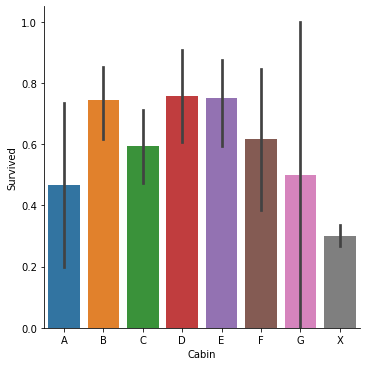

In [25]:
sns.catplot(y="Survived",x="Cabin",data=full_data,kind="bar", order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'X'])
# Standart deviation for the cabin catagories are very high due to small sample size however passangers with X as their cabin
# have lower standart deviation and survival rate then passangers with cabin with sort of backs our assumption that missing
# cabin data indicated passangers without cabins.

## Age:

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

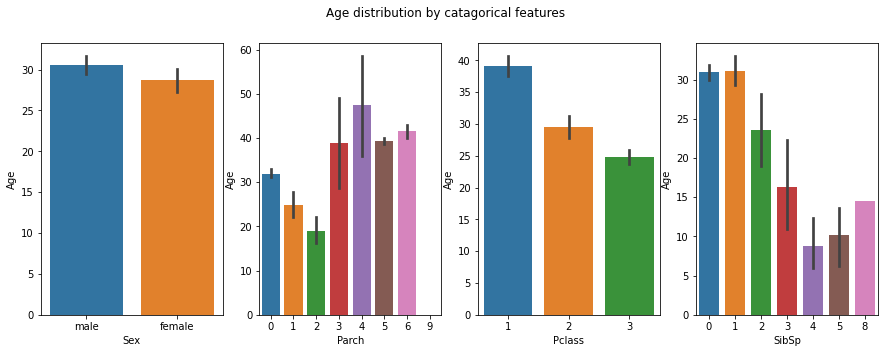

In [26]:
# we will impute missing Age values 
fig, axes = plt.subplots(1, 4, figsize= (15,5))
fig.suptitle('Age distribution by catagorical features')
sns.barplot(y= 'Age', x='Sex', data = full_data, ax=axes[0])
sns.barplot(y= 'Age', x='Parch', data = full_data, ax=axes[1])
sns.barplot(y= 'Age', x='Pclass', data = full_data, ax=axes[2])
sns.barplot(y= 'Age', x='SibSp', data = full_data, ax=axes[3])

In [27]:
#Pclass seems to do a good job at indicating age
full_data.Age = full_data.groupby('Pclass').Age.apply(lambda x: x.fillna(x.mean()))

## Fare:

In [33]:
#Fare in test is missing lets fill it
full_data.Fare = full_data.groupby('Pclass').Fare.apply(lambda x: x.fillna(x.mean()))

## Embarked:

In [34]:
# lets fill the embarked data with median since relatively low number of it is missing our imputation style shouldn't make much
# difference.

full_data.Embarked = full_data.Embarked.apply(lambda x: full_data.Embarked.mode()[0] if pd.isna(x) else x)

In [35]:
print('Any missing data:')
print(full_data.isnull().any())
print('-'*40)

Any missing data:
PassengerId    False
Survived        True
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool
----------------------------------------


# Data Analysis and Wrangling:

In [36]:
print(numeric)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


<AxesSubplot:>

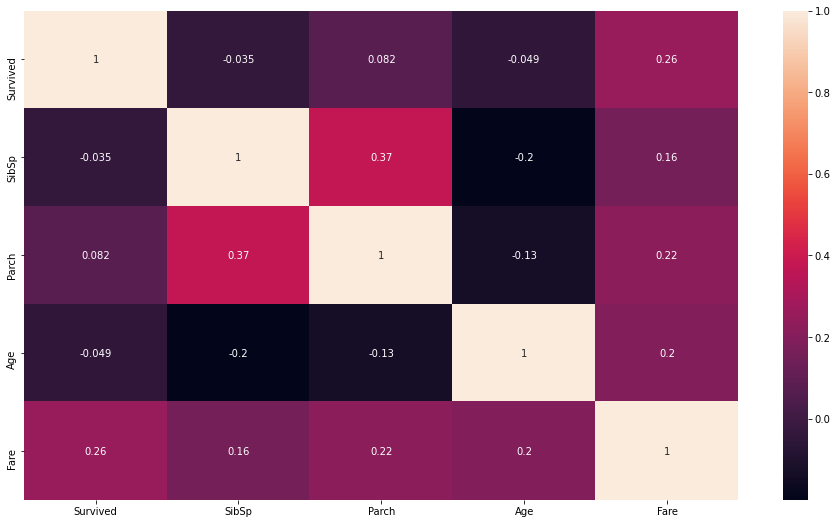

In [37]:
plt.figure(figsize=(16,9))
sns.heatmap(full_data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)

Fare seems to be a great indicator of survival, unfortunately money does save lives, Age and SibSp seems to have negative correlation and farely little correlation at that, however this does not mean those features are useless at indicating survival.

C:\Users\pc\anaconda3\envs\xg\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pc\anaconda3\envs\xg\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\pc\anaconda3\envs\xg\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\pc\anaconda3\e

([<matplotlib.axis.XTick at 0x1b7a3015d88>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

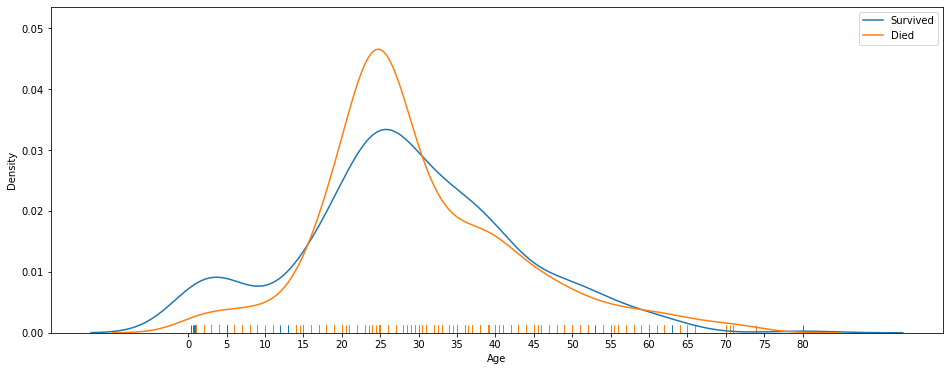

In [40]:
s = full_data.loc[full_data.Survived == 1]
d = full_data.loc[full_data.Survived == 0]
plt.figure(figsize=(16,6))
sns.distplot(s['Age'], hist=False, rug=True, label='Survived')
sns.distplot(d['Age'], hist=False, rug=True, label='Died')
plt.legend()
plt.xticks(list(range(0,81,5)))


The tail survived graph makes indicates children around 0-10 had a significantly higher chance of survival. Binning the age into several 

<AxesSubplot:xlabel='Survived', ylabel='Cabin'>

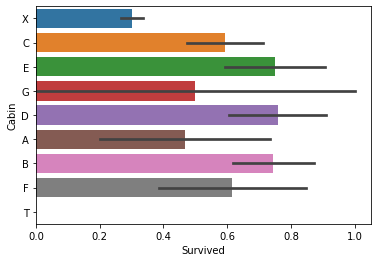

In [41]:
sns.barplot(x='Survived', y='Cabin', data=full_data)

Cabin data has a lot of standard devieation.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

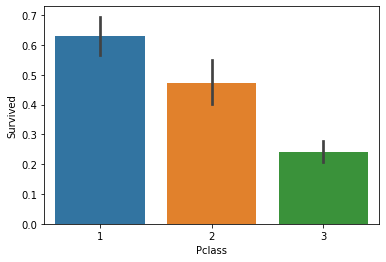

In [42]:
sns.barplot(x='Pclass', y='Survived', data=full_data)

Pclass has a lot of influence on survival rate, probably higher class passangers were prioritized when abording the ship.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

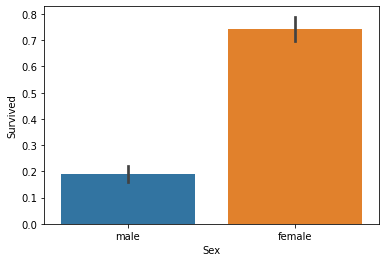

In [43]:
sns.barplot(x='Sex', y='Survived', data=full_data)

Women and children indeed seems to be prioritized when abording, but we can still check maybe males were predominant in lower Pclasses so that might be affecting some

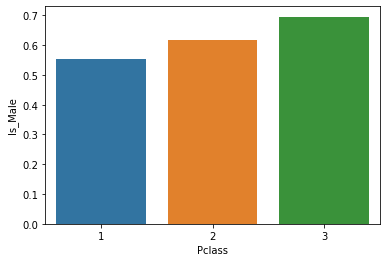

In [44]:
is_male = full_data.Sex.map({'male': 1, 'female': 0})
pclass_is_male = pd.concat([is_male, full_data.Pclass], axis=1)
pclass_is_male
pclass_is_male.rename(columns={"Sex": "Is_Male"}, inplace = True)
grp = pclass_is_male.groupby('Pclass').mean()
g = sns.barplot(x=grp.index, y=grp.Is_Male, data=grp)

Our assumption is somewhat true, in lower classes male passanger density is higher, but still sex on its own has a lot of affect on survival.

## Fare:

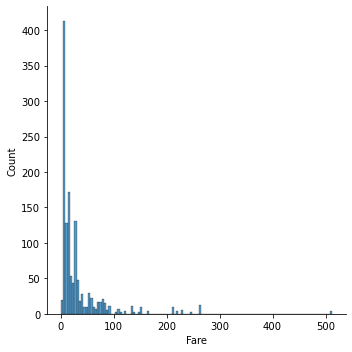

In [45]:
g = sns.displot(full_data.Fare)

In [46]:
full_data.Fare.skew()

4.369469816159841

This data is quite skewed and we want to bin the data, most likely according to Struge's Rule, and it works best on normally distributed data, so lets try normalizing. Also most models work better on normalized data.

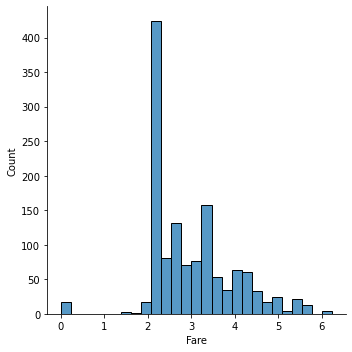

In [47]:
full_data.Fare = np.log(full_data.Fare + 1) # +1 for the 0 fares
test.Fare = np.log(test.Fare + 1)
g = sns.displot(full_data.Fare)

In [49]:
full_data.Fare.skew()

0.5427564049496318

# Feature Engineering

## Name:
We can use the name feature, and get titles and families information out of it

In [50]:
full_data.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [51]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

title = pd.Series(full_data.Name.apply(get_title))
full_data['Title'] = title

print('Test: \n{}' .format(full_data.Title.value_counts()))
print('-'*40)

Test: 
Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
the Countess      1
Mme               1
Capt              1
Sir               1
Don               1
Lady              1
Dona              1
Jonkheer          1
Name: Title, dtype: int64
----------------------------------------


Lets group rare titles together and make sure both train and test data frames have same Title values.

In [52]:
min_count = 10
full_data.Title = full_data.Title.map(lambda x: x if title.loc[title == x].count() > min_count else 'Rare')
print('Test: \n{}' .format(full_data.Title.value_counts()))
print('-'*40)

Test: 
Mr        757
Miss      260
Mrs       197
Master     61
Rare       34
Name: Title, dtype: int64
----------------------------------------


## Family Size, Is Alone:
Now lets create 2 more features from sibsp and parch features, and check if they have any apparent effect on survival rate.

In [53]:
full_data['IsAlone'] = full_data.apply(lambda x: 1 if (x.SibSp + x.Parch == 0) else 0, axis=1)
full_data['FamilySize'] = full_data.agg(lambda x: x.SibSp+x.Parch+1, axis=1)
full_data.head()
#the features are created correcty

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsAlone,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,2.110213,X,S,Mr,0,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.280593,C,C,Mrs,0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.188856,X,S,Miss,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.990834,C,S,Mrs,0,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.202765,X,S,Mr,1,1


<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

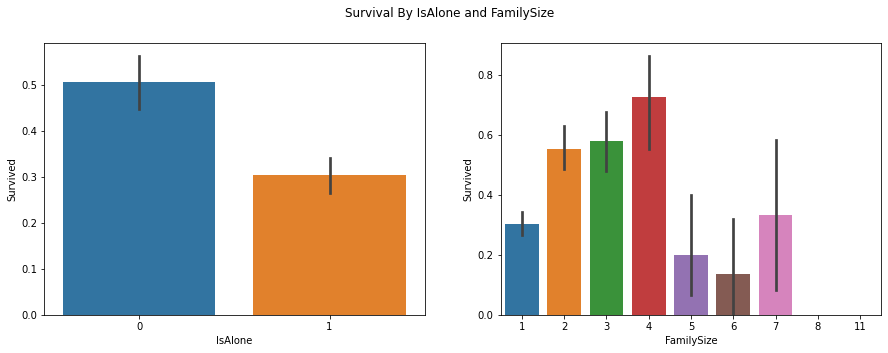

In [54]:
fig, axes = plt.subplots(1, 2, figsize= (15,5))
fig.suptitle('Survival By IsAlone and FamilySize')
sns.barplot(x='IsAlone', y='Survived', data=full_data, ax=axes[0])
sns.barplot(x='FamilySize', y='Survived', data=full_data, ax=axes[1])

It seems like small families with 2 to 4 members had a high chance of survival and large families struggled to survive, alone passangers seems to have a low survival rate but that may be because alone passangers tend to be male or low pclass, lets check for that.

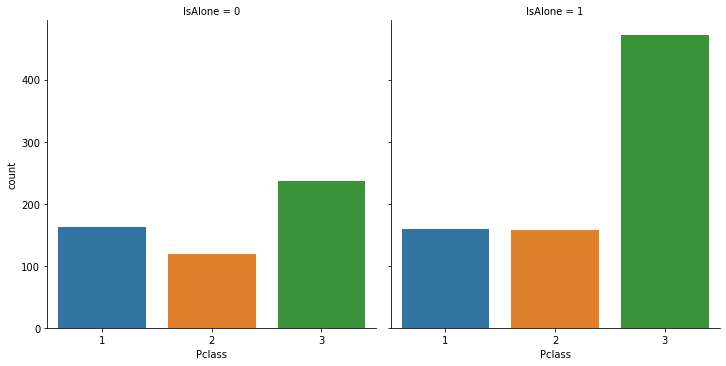

In [55]:
g = sns.catplot(x="Pclass", col="IsAlone",
                data=full_data,
                kind="count")

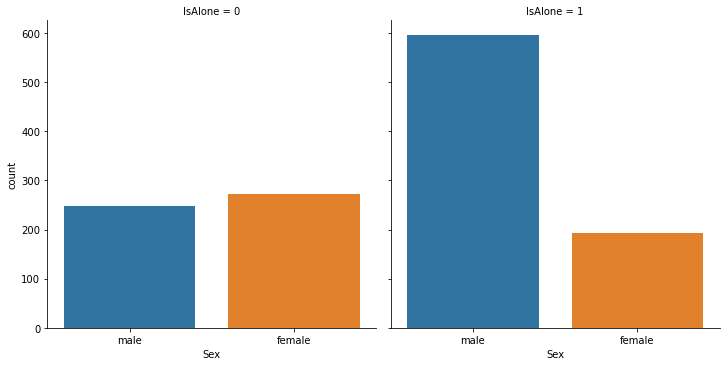

In [56]:
g = sns.catplot(x="Sex", col="IsAlone",
                data=full_data,
                kind="count")

Indeed, alone passangers are far more likely to be lower class and also male, both of which decreases the odds of survival, still we'll keep the IsAlone feature for now.

# Data Transformation:
## Binning Continious Varaibles:

In [57]:
full_data.Age.max()

80.0

In [59]:
age_groups = ["infant","child","teenager","youngAdult","adult","aged"]
age_ranges = [0,5,12,18,35,60,81]
full_data['AgeBinned'] = pd.cut(full_data.Age, age_ranges, labels=age_groups)
full_data['AgeBinnedNumeric'] = full_data.AgeBinned.map({"infant": 0,"child": 1,"teenager": 2,"youngAdult": 3,"adult": 4,"aged": 5})
display(full_data[['AgeBinned', 'AgeBinnedNumeric','Age']]);

,AgeBinned,AgeBinnedNumeric,Age
0,youngAdult,3,22.000000
1,adult,4,38.000000
2,youngAdult,3,26.000000
3,youngAdult,3,35.000000
4,youngAdult,3,35.000000
...,...,...,...
1304,youngAdult,3,24.816367
1305,adult,4,39.000000
1306,adult,4,38.500000
1307,youngAdult,3,24.816367


In [60]:
full_data['FareBinned'] = pd.cut(full_data.Fare, 5, labels=['very_low', 'low', 'mid', 'high', 'very_high'])

In [61]:
full_data.FareBinned.unique()

['low', 'high', 'mid', 'very_high', 'very_low']
Categories (5, object): ['very_low' < 'low' < 'mid' < 'high' < 'very_high']

In [62]:
full_data['FareBinnedNumeric'] = full_data.FareBinned.map({'very_low': 0, 'low': 1, 'mid': 2, 'high': 3, 'very_high': 4})

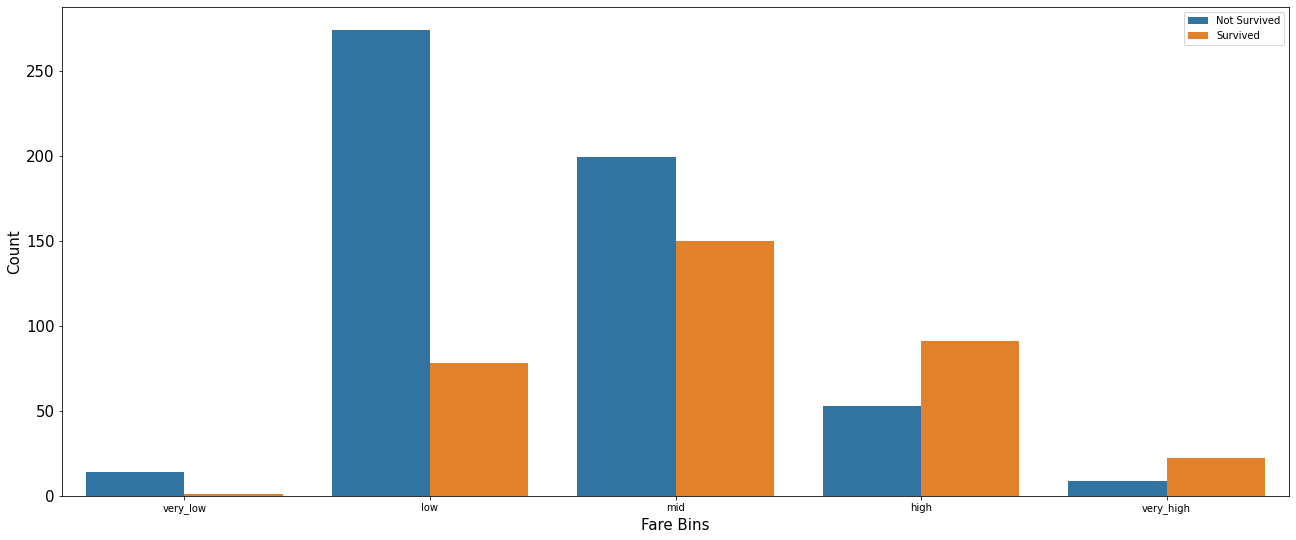

In [63]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='FareBinned', hue='Survived', data=full_data)

plt.xlabel('Fare Bins', size=15)
plt.ylabel('Count', size=15)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'])

plt.show()

In [64]:
full_data.dtypes

PassengerId             int64
Survived              float64
Pclass                  int64
Name                   object
Sex                    object
Age                   float64
SibSp                   int64
Parch                   int64
Ticket                 object
Fare                  float64
Cabin                  object
Embarked               object
Title                  object
IsAlone                 int64
FamilySize              int64
AgeBinned            category
AgeBinnedNumeric     category
FareBinned           category
FareBinnedNumeric    category
dtype: object

In [65]:
full_data = pd.get_dummies(full_data, columns=['Sex', 'Cabin', 'Embarked', 'Title'], drop_first=True)

In [66]:
columns = full_data.columns.tolist()
columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'IsAlone',
 'FamilySize',
 'AgeBinned',
 'AgeBinnedNumeric',
 'FareBinned',
 'FareBinnedNumeric',
 'Sex_male',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_X',
 'Embarked_Q',
 'Embarked_S',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare']

In [67]:
cols_to_remove = ['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'AgeBinned', 'FareBinned', 'Survived']
usable_columns = [feature for feature in columns if feature not in cols_to_remove]
full_data[usable_columns].dtypes

Pclass                  int64
IsAlone                 int64
FamilySize              int64
AgeBinnedNumeric     category
FareBinnedNumeric    category
Sex_male                uint8
Cabin_B                 uint8
Cabin_C                 uint8
Cabin_D                 uint8
Cabin_E                 uint8
Cabin_F                 uint8
Cabin_G                 uint8
Cabin_T                 uint8
Cabin_X                 uint8
Embarked_Q              uint8
Embarked_S              uint8
Title_Miss              uint8
Title_Mr                uint8
Title_Mrs               uint8
Title_Rare              uint8
dtype: object

In [68]:
full_data[['AgeBinnedNumeric', 'FareBinnedNumeric']] = full_data[['AgeBinnedNumeric', 'FareBinnedNumeric']].astype(int)

In [69]:
full_data[usable_columns]

,Pclass,IsAlone,FamilySize,AgeBinnedNumeric,FareBinnedNumeric,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,0,2,3,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1,1,0,2,4,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,3,1,1,3,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
3,1,0,2,3,3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,3,1,1,3,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,1,3,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1305,1,1,1,4,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1306,3,1,1,4,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1307,3,1,1,3,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0


In [70]:
usable_columns

['Pclass',
 'IsAlone',
 'FamilySize',
 'AgeBinnedNumeric',
 'FareBinnedNumeric',
 'Sex_male',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_X',
 'Embarked_Q',
 'Embarked_S',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare']

# Model Creation, Selection and Tuning

In [71]:
# import the models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# import model selection tools
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score



In [83]:
train = full_data[:891]
test = full_data[891:]
trainX = train[usable_columns]
trainy = train['Survived']
testX = test[usable_columns]

In [84]:

seed = 21
lr = LogisticRegression(random_state = seed)
svc = SVC(random_state = seed)
rfc = RandomForestClassifier(random_state = seed)
abc = AdaBoostClassifier(random_state = seed)
gbc = GradientBoostingClassifier(random_state = seed)
etc = ExtraTreesClassifier(random_state = seed)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state = seed)
xgbc = XGBClassifier(random_state = seed)
models = [
    (lr, "LR"),
    (svc, "SVC"),
    (rfc, "RFC"),
    (abc, "ABC"),
    (gbc, "GBC"),
    (etc, "ETC"),
    (knc, "KNC"),
    (dtc, "DTC"),
    (xgbc, "XGBC")
]


In [85]:
xValScores = []
model_names = []
for model, model_name in models:
    score = cross_val_score(model, trainX, trainy, cv=10).mean()
    xValScores.append(score)
    model_names.append(model_name)
    

In [86]:
scores_df = pd.DataFrame(xValScores, columns =['Model Scores'])
scores_df["Model Names"] = pd.Series(model_names)
scores_df.sort_values('Model Scores', ascending=False)

,Model Scores,Model Names
0,0.833933,LR
1,0.830537,SVC
8,0.828302,XGBC
2,0.826067,RFC
4,0.821573,GBC
3,0.811511,ABC
5,0.811473,ETC
6,0.810375,KNC
7,0.808127,DTC


In [56]:
# we will tune hyper parameters for LR, SVC, XGBC, RFC, GBC

In [57]:
"""# LR parameters
lrParams = {
    "penalty" : ["l1", "l2", "elasticnet", None],
    "C" : [0.5, 1.0, 2, 4],
    "random_state": [seed]
}
# SVC parameters
svcParams = {
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.001, 0.01, 0.1, 1, 10 ],
    "C": [0.1,1, 1.5, 3],
    "degree": [0, 1, 3]
}



# GBC parameters
gbcParams = {
    "min_samples_split": [2, 4, 8, 16],
    "min_samples_leaf" : [1, 4, 8, 12],
    "max_depth": [4, 6, 8, 12],
    "max_features": ["sqrt", "log2", None],
    "random_state": [seed]
}
# RFC parameters
rfcParams = {
    'n_estimators': [3, 10, 15, 20, 25, 30],
    'max_features': [2, 4, 5, 6, 7],
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5]
}
#XGBC
#xgbcParams={
#    "learning_rate" : [.4, .45, .5, .55, .6],
#     "max_depth": [7, 10, 13]
#    "n_estimators" : [8, 11, 14, 17],
#    "colsample_bytree": [.6, .7, .8, .9, 1]
#}
params_models = [(lrParams, lr, "LR"), (svcParams, svc, "SVC"),                  
                 (gbcParams, gbc, "GBC"), (rfcParams, rfc, "RFC"), #(xgbcParams, xgbc, "XGBC")]"""

'# LR parameters\nlrParams = {\n    "penalty" : ["l1", "l2", "elasticnet", None],\n    "C" : [0.5, 1.0, 2, 4],\n    "random_state": [seed]\n}\n# SVC parameters\nsvcParams = {\n    "kernel": ["linear", "rbf", "poly"],\n    "gamma": [0.001, 0.01, 0.1, 1, 10 ],\n    "C": [0.1,1, 1.5, 3],\n    "degree": [0, 1, 3]\n}\n\n\n\n# GBC parameters\ngbcParams = {\n    "min_samples_split": [2, 4, 8, 16],\n    "min_samples_leaf" : [1, 4, 8, 12],\n    "max_depth": [4, 6, 8, 12],\n    "max_features": ["sqrt", "log2", None],\n    "random_state": [seed]\n}\n# RFC parameters\nrfcParams = {\n    \'n_estimators\': [3, 10, 15, 20, 25, 30],\n    \'max_features\': [2, 4, 5, 6, 7],\n    \'bootstrap\': [True, False],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'min_samples_split\': [2, 5]\n}\n#XGBC\n#xgbcParams={\n#    "learning_rate" : [.4, .45, .5, .55, .6],\n#     "max_depth": [7, 10, 13]\n#    "n_estimators" : [8, 11, 14, 17],\n#    "colsample_bytree": [.6, .7, .8, .9, 1]\n#}\nparams_models = [(lrParams, lr,

In [58]:
"""best_params = []
best_scores = []
for param, model, model_name in params_models:
    gridSearch = GridSearchCV(model, param, verbose=0, cv=8, scoring="accuracy", n_jobs = -1)
    gridSearch.fit(data1[usable_columns], data1['Survived'])
    best_params.append(gridSearch.best_params_)
    best_scores.append((gridSearch.best_score_, model_name))
        """

'best_params = []\nbest_scores = []\nfor param, model, model_name in params_models:\n    gridSearch = GridSearchCV(model, param, verbose=0, cv=8, scoring="accuracy", n_jobs = -1)\n    gridSearch.fit(data1[usable_columns], data1[\'Survived\'])\n    best_params.append(gridSearch.best_params_)\n    best_scores.append((gridSearch.best_score_, model_name))\n        '

Let's save the best parameters, because it takes a long time to run the grid search and this way we won't have to rerun it every time we open the notebook.

In [59]:
"""best_params[0] # lrParams {'C': 0.5, 'penalty': 'l2', 'random_state': 21}"""

"best_params[0] # lrParams {'C': 0.5, 'penalty': 'l2', 'random_state': 21}"

In [60]:
"""best_params[1] # svcParams {'C': 1.5, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf'}"""

"best_params[1] # svcParams {'C': 1.5, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf'}"

In [61]:
"""best_params[2] # gbcParams {'max_depth': 8,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 4,
# 'min_samples_split': 16,
# 'random_state': 21}"""

"best_params[2] # gbcParams {'max_depth': 8,\n# 'max_features': 'sqrt',\n# 'min_samples_leaf': 4,\n# 'min_samples_split': 16,\n# 'random_state': 21}"

In [62]:
"""best_params[3] # rfcParams {'bootstrap': False,
                            # 'max_features': 7,
                            #'min_samples_leaf': 2,
                            # 'min_samples_split': 2,
                            # 'n_estimators': 15}"""

"best_params[3] # rfcParams {'bootstrap': False,\n                            # 'max_features': 7,\n                            #'min_samples_leaf': 2,\n                            # 'min_samples_split': 2,\n                            # 'n_estimators': 15}"

In [63]:
"""best_params[4] # xgbcparams {'n_estimators': 11,
                             #'max_depth': 7,
                             #'learning_rate': 0.55,
                             #'colsample_bytree': 0.8}"""

"best_params[4] # xgbcparams {'n_estimators': 11,\n                             #'max_depth': 7,\n                             #'learning_rate': 0.55,\n                             #'colsample_bytree': 0.8}"

In [64]:
"""tuned_scores_df = pd.DataFrame(best_scores, columns =['Model Scores', 'Model Names'])
tuned_scores_df = tuned_scores_df.sort_values('Model Scores', ascending=False)
tuned_scores_df
tuned_scores_df.reset_index(drop=True)"""

NameError: name 'best_scores' is not defined

In [ ]:
"""old_scores = scores_df.loc[scores_df["Model Names"].map(lambda x: x in ["RFC", "XGBC", "GBC", "SVC", "LR"]), :].sort_values('Model Scores', ascending=False)
old_scores.reset_index(drop=True)"""

In [ ]:
"""tuned_scores_alphabetical = tuned_scores_df.sort_values("Model Names").reset_index(drop=True)
old_scores_alphabetical = old_scores.sort_values("Model Names").reset_index(drop=True)
old_scores_alphabetical.drop(["Model Names"], inplace=True, axis=1)"""

In [ ]:
"""old_scores_alphabetical.rename(columns={"Model Scores": "Old Scores"}, inplace=True)
tuned_scores_alphabetical.rename(columns={"Model Scores": "Tuned Scores"}, inplace=True)
old_and_tuned = pd.concat([old_scores_alphabetical, tuned_scores_alphabetical], axis=1)"""

In [ ]:
"""old_and_tuned['Change'] = old_and_tuned['Tuned Scores'] - old_and_tuned['Old Scores']"""

In [ ]:
"""old_and_tuned"""

In [ ]:
"""sns.barplot(x='Model Names', y='Change', data=old_and_tuned)"""

Outside of LR all models improved, we'll use default parameters for it, I used a poor parameter grid probably.

In [87]:
#code from scikit-learn.org
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    return plt

In [106]:
lr = LogisticRegression(max_iter=150)
svc = SVC(C=1.5, degree= 0, gamma= 0.1, kernel = 'rbf', random_state=seed)
gbc = GradientBoostingClassifier(max_depth=8, max_features= 'sqrt', min_samples_leaf=4, min_samples_split=16, random_state=seed)
rfc = RandomForestClassifier(bootstrap= False, max_features= 7, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 15)
xgbc = XGBClassifier(n_estimators=11, max_depth=7, learning_rate = 0.55, colsample_bytree=0.8)

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\anaconda3\\envs\\xg\\lib\\site-packages\\matplotlib\\pyplot.py'>

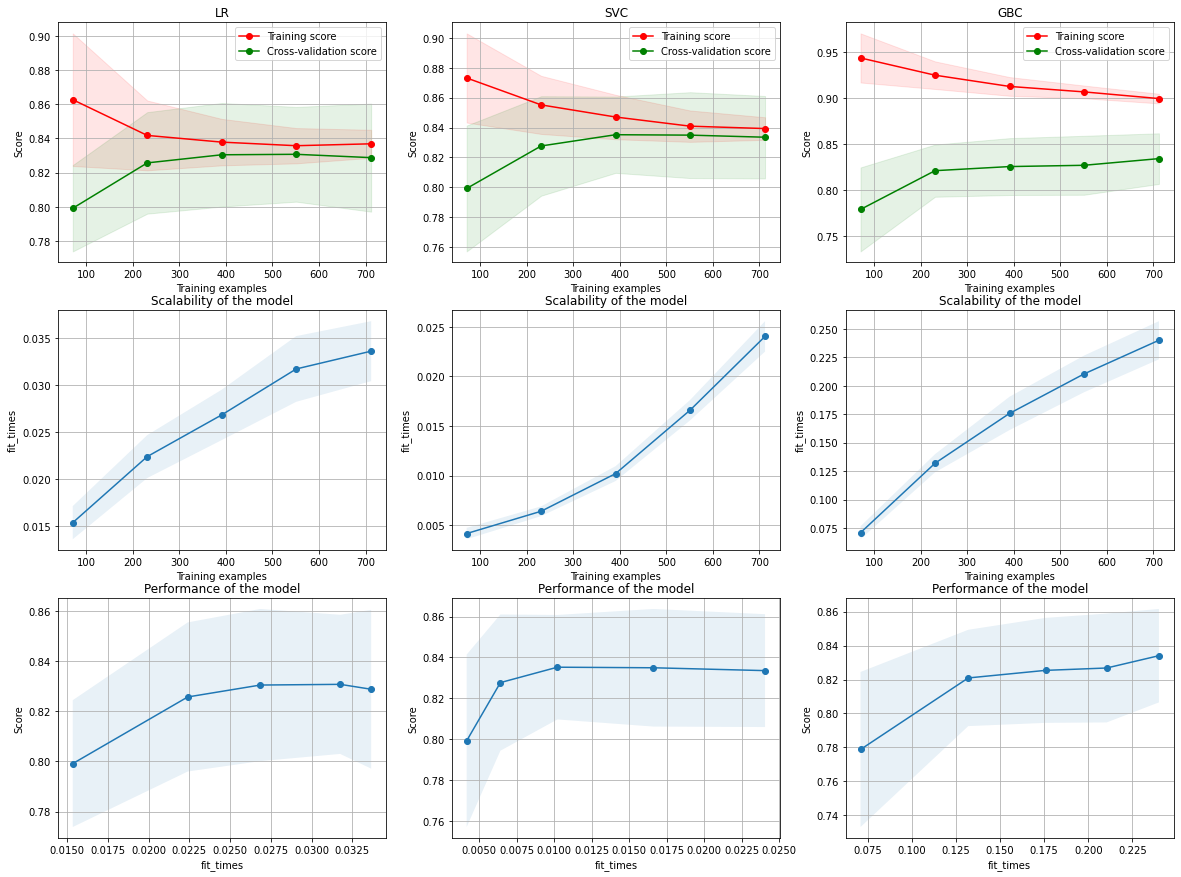

In [89]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
plot_learning_curve(lr, 'LR', trainX, trainy, axes=axes[:, 0], ylim=None, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(svc, 'SVC', trainX, trainy, axes=axes[:, 1], ylim=None, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(gbc, 'GBC', trainX, trainy, axes=axes[:, 2], ylim=None, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\anaconda3\\envs\\xg\\lib\\site-packages\\matplotlib\\pyplot.py'>

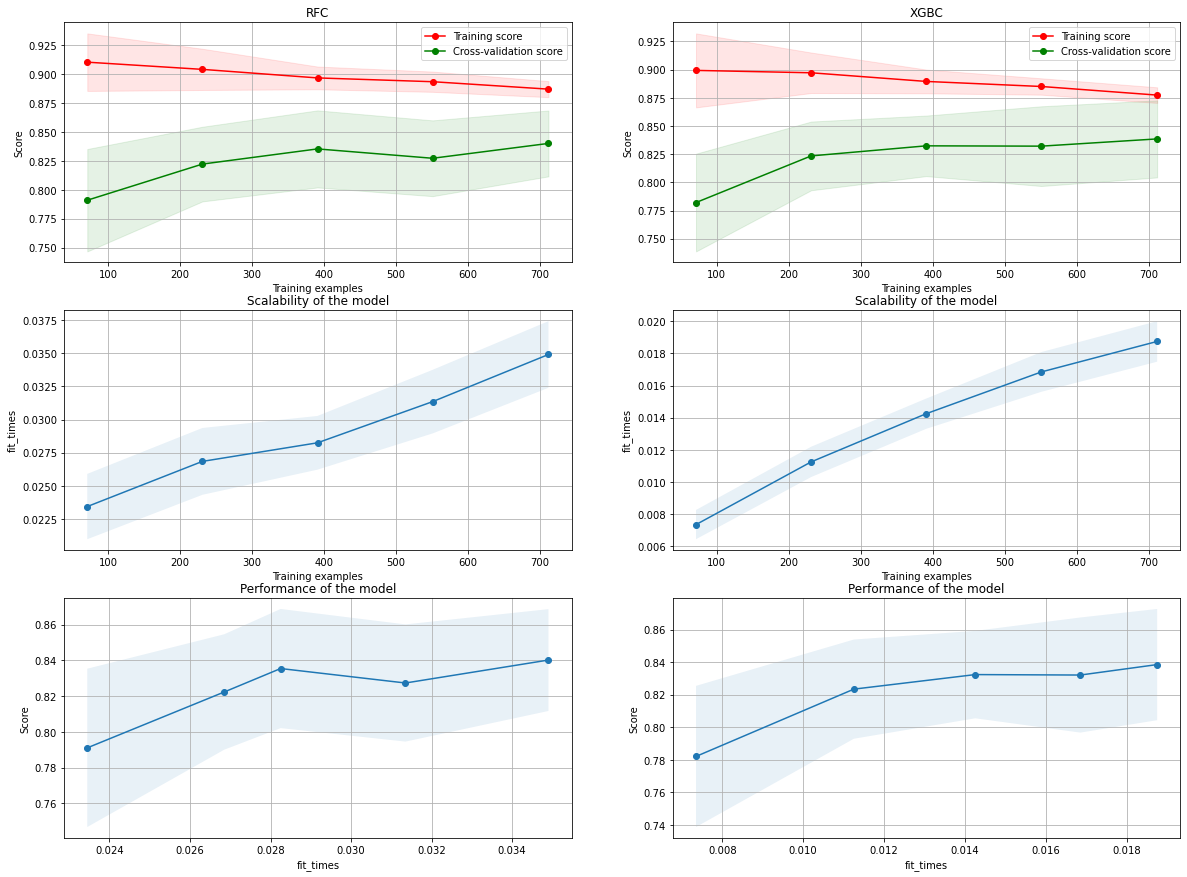

In [68]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
plot_learning_curve(rfc, 'RFC', trainX, trainy, axes=axes[:, 0], ylim=None, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(xgbc, 'XGBC', trainX, trainy, axes=axes[:, 1], ylim=None, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))

In [107]:
svc.fit(trainX, trainy)
lr.fit(trainX, trainy)
rfc.fit(trainX, trainy)
gbc.fit(trainX, trainy)
xgbc.fit(trainX, trainy)


gbcPredictions = pd.Series(gbc.predict(testX), name="GBC")
svcPredictions = pd.Series(svc.predict(testX), name="SVC")
lrPredictions = pd.Series(lr.predict(testX), name="LR")
rfcPredictions = pd.Series(rfc.predict(testX), name="RFC")
xgbcPredictions = pd.Series(xgbc.predict(testX), name="XGBC")

all_predictions = pd.concat([gbcPredictions, svcPredictions, lrPredictions, rfcPredictions, xgbcPredictions],axis=1)

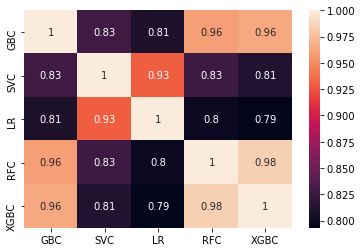

In [108]:
g= sns.heatmap(all_predictions.corr(),annot=True)
# for some reason models guesses are very different compared to eachother, I will look into that later

In [77]:
rfc = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(data1[usable_columns], data1['Survived'], test_size=0.33, random_state=42)
rfc.fit(X_train, y_train)
xp = rfc.predict(X_test)
accuracy_score(xp, y_test)

0.8

# Ensambling:
I will ensamble the models to groups, but I do not want groups like XGBC-RFC-GBC dominating so I will choose 2 of them and LR-SVC in the esnamble

In [123]:
vc = VotingClassifier(estimators=[('RFC', rfc), ('XGBC', xgbc),
('SVC', svc), ('LR', lr, ('GBC', gbc))], voting='hard', n_jobs=4)

vc.fit(trainX, trainy)

ValueError: too many values to unpack (expected 2)

# Submission

In [121]:
competition_predictions = pd.Series(vc.predict(testX).astype(int), name="Survived")
pass_id = test['PassengerId'].reset_index(drop=True)
predictions_kaggle_format = pd.concat([pass_id,competition_predictions],axis=1)

predictions_kaggle_format.to_csv("titanic_hardvote_predictions.csv",index=False)

In [122]:
predictions_kaggle_format

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
